In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import diags, eye, kron, csr_matrix
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
import pickle
import netCDF4 as nc

from scipy.interpolate import griddata
from scipy.optimize import minimize_scalar


In [2]:
def calculate_eddy(width=500e3, num_depth_layers=21, eta0=1, L=1e5, H=1000,
                   a=1, b=1, rho0=1025, f0=None,
                   alpha_1=0.01, alpha_2=0.01,
                   T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None,
                   q11=1.0, q12=0.0, q22=1.0):
    """
    Compute 3D geostrophic U,V and fields for an eddy with prescribed
    quadratic-form shape coefficients q11,q12,q22 (constant in z).
    """
    if f0 is None:
        f0 = 2 * 7.29e-5 * np.sin(np.radians(-34))
    g = 9.81

    x = np.linspace(-width/2, width/2, 51)
    y = np.linspace(-width/2, width/2, 51)
    z = np.linspace(-H, 0, num_depth_layers)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    taper = np.exp(Z / taper_depth) if taper_depth is not None else 1.0

    # center shift with depth
    Xc = alpha_1 * Z
    Yc = alpha_2 * Z

    # elliptical radius-squared
    dX = X - Xc
    dY = Y - Yc
    r2Q = q11 * dX**2 + 2*q12 * dX * dY + q22 * dY**2

    phi = np.exp(-r2Q / L**2) * taper

    T = -2 * phi
    S = 1.5 * phi
    P = -rho0 * g * Z

    alpha = 2e-4
    beta  = 8e-4
    sigma = rho0 * (1 - alpha*(T - T0) + beta*(S - 35))
    sigma -= sigma.mean()

    dx, dy = x[1]-x[0], y[1]-y[0]
    dsdx = np.gradient(sigma, dx, axis=0)
    dsdy = np.gradient(sigma, dy, axis=1)

    U =  g/f0 * dsdy * taper
    V = -g/f0 * dsdx * taper

    # flip so z=0 is first index
    U, V, sigma, T, S, P = [np.flip(arr, axis=2) for arr in (U,V,sigma,T,S,P)]
    z = z[::-1]

    # transpose horizontal slices
    for k in range(U.shape[2]):
        U[:,:,k] = U[:,:,k].T
        V[:,:,k] = V[:,:,k].T

    return U, V, sigma, T, S, P, x/1000, y/1000, z/1000


In [3]:
def dopioe(x1, y1, u1, v1, x2, y2, u2, v2):
    def find_root(x, y, degree=3):
        """Fit a degree-3 polynomial to (x, y) and return the real root closest to x's midpoint."""
        coeffs = np.polyfit(x, y, degree)
        roots = np.roots(np.poly1d(coeffs))
        real_roots = roots[np.isreal(roots)].real
        mid_x = x[len(x) // 2]
        return real_roots[np.argmin(np.abs(real_roots - mid_x))]
    
    def tangent_at_root(x, y, root_x, degree=3):
        coeffs = np.polyfit(x, y, degree)
        slope = np.polyval(np.polyder(coeffs), root_x)
        intercept = np.polyval(coeffs, root_x) - slope * root_x
        y_fit = np.polyval(coeffs, x)
        r2 = 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2) if np.sum((y - np.mean(y))**2) != 0 else 1.0
        return slope, intercept, r2

    if np.any(np.isnan(u1)) or np.any(np.isnan(u2)):
        return np.nan, np.nan, np.nan, np.nan

    points1 = set(zip(x1, y1))
    points2 = set(zip(x2, y2))
    common_points = points1 & points2
    
    if len(common_points) != 1:
        print(f"Warning: Expected 1 common point, found {len(common_points)}.")
        return np.nan, np.nan, np.nan, np.nan
    
    center_x, center_y = next(iter(common_points))

    xx = x1 - center_x
    yy = y2 - center_y

    # Compute roots and tangents
    root_x = find_root(xx, v1)
    A1, A0, r2A = tangent_at_root(xx, u1, root_x)
    B1, B0, r2B = tangent_at_root(xx, v1, root_x)
    root_y = find_root(yy, u2)
    C1, C0, r2C = tangent_at_root(yy, u2, root_y)
    D1, D0, r2D = tangent_at_root(yy, v2, root_y)
    
    alpha = A0 if r2A > r2C else C0
    beta  = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    
    q11 = B1 / 2
    q22 = -C1 / 2
    q12 = -gamma / 2
    denom = C1 * B1 + gamma**2
    if denom == 0:
        raise ZeroDivisionError("Denominator is zero.")
        
    x0 = - (alpha * gamma + beta * C1) / denom
    y0 = (beta * gamma - alpha * B1) / denom
    w = 2 * (q11 + q22)

    Q = np.array([[q11, q12], [q12, q22]])

    return x0 + center_x, y0 + center_y, w, Q
    

In [4]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=400)
X, Y, dx = *np.meshgrid(x, y), x[1] - x[0]
dx


np.float64(10.0)

-0.018345277084503647 9.2674982314817e-05 -0.018345277084503647


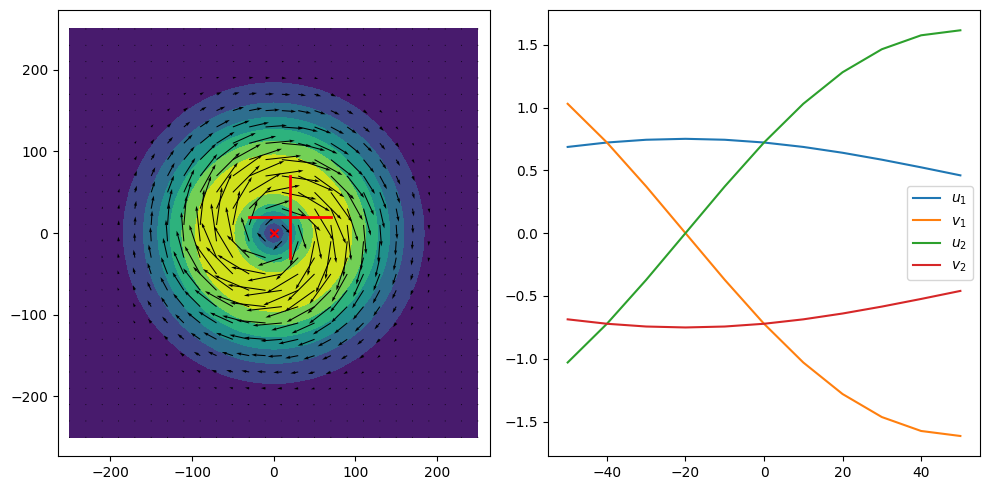

In [5]:
k = 0
u, v = U[:,:,k], V[:,:,k]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].contourf(X, Y, np.hypot(u, v))
spacing = 2
axs[0].quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing], u[::spacing, ::spacing], v[::spacing, ::spacing])
axs[0].axis('equal')

ic, jc, rc = X.shape[0]//2 + 2, X.shape[1]//2 + 2, 5

u1 = u.T[ic - rc: ic + rc + 1, jc]
v1 = v.T[ic - rc: ic + rc + 1, jc]
x1 = X.T[ic - rc: ic + rc + 1, jc]
y1 = Y.T[ic - rc: ic + rc + 1, jc]
u2 = u.T[ic, jc - rc: jc + rc + 1]
v2 = v.T[ic, jc - rc: jc + rc + 1]
x2 = X.T[ic, jc - rc: jc + rc + 1]
y2 = Y.T[ic, jc - rc: jc + rc + 1]

x0, y0, w, Q = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
q11, q12, q22 = Q[0,0], Q[1,0], Q[1,1]
print(q11, q12, q22)

q11, q12, q22 = np.abs(q11), np.abs(q12), np.abs(q22)

axs[0].scatter(x0, y0, marker='x', color='r')

points1 = set(zip(x1, y1))
points2 = set(zip(x2, y2))
common_points = points1 & points2
center_x, center_y = next(iter(common_points))
xx = x1 - center_x
yy = y2 - center_y

axs[0].plot(x1, y1, 'r', linewidth=2)
axs[0].plot(x2, y2, 'r', linewidth=2)

axs[1].plot(xx, u1, label=r'$u_1$')
axs[1].plot(xx, v1, label=r'$v_1$')
axs[1].plot(yy, u2, label=r'$u_2$')
axs[1].plot(yy, v2, label=r'$v_2$')
axs[1].legend()

plt.tight_layout()
plt.show()


## Eddy Velocity Field Retrieval

We define an **elliptical Gaussian eddy** using a streamfunction

$$
\psi(x, y) = \exp\left(-\frac{1}{R^2} \phi(x, y)\right)
$$

where the scalar field $\phi$ is quadratic in $x$ and $y$

$$
\phi(x, y) = q_{11}(x - x_0)^2 + 2q_{12}(x - x_0)(y - y_0) + q_{22}(y - y_0)^2.
$$

This gives an elliptical shape controlled by the symmetric matrix $Q$

$$
Q = \begin{bmatrix}
q_{11} & q_{12} \\
q_{12} & q_{22}
\end{bmatrix}.
$$

The geostrophic velocity field is derived from the streamfunction via

$$
u = -\frac{\partial \psi}{\partial y}, \quad v = \frac{\partial \psi}{\partial x}.
$$

We compute the gradients using the chain rule

$$
\frac{\partial \psi}{\partial x} = -\frac{1}{R^2} \frac{\partial \phi}{\partial x} \exp\left(-\frac{1}{R^2} \phi\right), \quad
\frac{\partial \psi}{\partial y} = -\frac{1}{R^2} \frac{\partial \phi}{\partial y} \exp\left(-\frac{1}{R^2} \phi\right)
$$

with

$$
\frac{\partial \phi}{\partial x} = 2q_{11}(x - x_0) + 2q_{12}(y - y_0),
$$
$$
\frac{\partial \phi}{\partial y} = 2q_{22}(y - y_0) + 2q_{12}(x - x_0).
$$
Lets look at the normal velocity along a horizontal transect $y=0$ (but the transect isnt taken at y=0, we actually find where the transect is taken relative to the eddy center, i.e. the distance of closest approach)
$$ 
V_N = -\frac{2q_{12}y_0-2q_{11}(x-x_0)}{R^2}\exp\left(-\frac{q_{11}(x-x_0)^2-2q_{12}(x-x_0)y_0+q_{22}y_0^2}{R^2}\right)
$$
$$
V_N =\frac{1}{R^2}(Ax+B)\exp\left( -\frac{1}{R^2}(Cx^2+Dx+E) \right)
$$
where
$$ 
A=2q_{11}, \quad B=-2(q_{12}y_0+q_{11}x_0), \quad C=q_{11}, \quad D=-2(x_0q_{11}+q_{12}y_0), \quad E=q_{11}x_0^2+2q_{12}x_0y_0+q_{22}y_0^2
$$
we know the above values, hence we can solve to find optimal $R$. Note that
$$
A=2C, \quad D=B=\phi_x(0,0), \quad E=\phi(0,0)
$$
\
\
Can do the same for the tangential component
$$ 
V_T = \frac{2q_{12}(x-x_0)-2q_{22}y_0}{R^2}\exp\left(-\frac{q_{11}(x-x_0)^2-2q_{12}(x-x_0)y_0+q_{22}y_0^2}{R^2}\right)
$$
$$
V_T =\frac{1}{R^2}(Fx+G)\exp\left( -\frac{1}{R^2}(Cx^2+Dx+E) \right)
$$
where
$$ 
F=2q_{12}, \quad G=-2q_{12}x_0-2q_{22}y_0, \quad C=q_{11}, \quad D=-2(x_0q_{11}+q_{12}y_0), \quad E=q_{11}x_0^2+2q_{12}x_0y_0+q_{22}y_0^2.
$$

### Best method

In [6]:
q11, q12, q22

(np.float64(0.018345277084503647),
 np.float64(9.2674982314817e-05),
 np.float64(0.018345277084503647))

In [7]:
# def fit_Rc(x1, v1, q11, q12, q22, x0, y0):
#     from scipy.optimize import minimize_scalar

#     y_T = y1[0] - y0 # Transect relative to the eddy center

#     C = q11
#     B = -2*q11*x0 + 2*q12*(y_T - y0)
#     E = q11*x0**2 - 2*q12*x0*(y_T - y0) + q22*(y_T - y0)**2

#     def VN(Rc):
#         return - (2*C*x1 + B) / Rc**2 * np.exp(-(np.abs(C)*x1**2 + B*x1 + E) / Rc**2)

#     def obj(Rc):
#         return np.inf if Rc <= 0 else np.sum((v1 - VN(Rc))**2)

#     res = minimize_scalar(obj,
#                           bounds=(1e-6, 100),
#                           method='bounded')
#     if not res.success:
#         raise RuntimeError("Rc optimization failed")
#     return res.x

# def fit_Rc(x1, v1, q11, q12, q22, x0, y0):
#     from scipy.optimize import minimize
#     y_T = y1[0] - y0
#     def obj(p):
#         scale, Rc = p
#         # enforce positivity
#         if scale <= 0 or Rc <= 0:
#             return np.inf

#         # scaled quadratic terms
#         # q11s, q12s, q22s = scale*q11, scale*q12, scale*q22
#         q11s, q12s, q22s = q11, q12, q22

#         # build C, B, E
#         C = q11s
#         B = -2*q11s*x0 + 2*q12s*y_T
#         E = q11s*x0**2 - 2*q12s*x0*y_T + q22s*y_T**2

#         # modelled V_N
#         exponent = -(C*x1**2 + B*x1 + E) / Rc**2
#         VN = - (2*C*x1 + B) / Rc**2 * np.exp(exponent)

#         VN *= scale

#         # sum of squared errors
#         return np.sum((v1 - VN)**2)

#     # initial guess: scale=1, Rc~median|x1|
#     p0 = np.array([1.0, 10])
#     bounds = [(1e-6, None), (5, 20)]

#     res = minimize(obj, p0, bounds=bounds, method='L-BFGS-B')
#     if not res.success:
#         raise RuntimeError("Optimization failed: " + res.message)

#     return res.x  # [scale_opt, Rc_opt]


def fit_Rc(x1, y1, v1, q11, q12, q22, x0, y0,
           scale0=1.0, Rc0=10,
           bounds_scale=(1e-6, None), bounds_Rc=(1, 15)):
    from scipy.optimize import minimize
    """
    Fit (scale, Rc) so that
      VN(x) = scale * [-(2*C*x + B)/Rc^2 * exp(-(C*x^2 + B*x + E)/Rc^2)]
    matches the observed v1 along the horizontal transect (x1,y1).

    Inputs:
      x1, y1, v1      : 1D arrays of transect coords & observed V
      q11,q12,q22     : base quadratic coefficients
      x0, y0          : eddy centre
      scale0, Rc0     : initial guesses; Rc0 defaults to median|x1|
      bounds_scale    : (min, max) for scale
      bounds_Rc       : (min, max) for Rc

    Returns:
      scale_opt, Rc_opt
    """
    # relative transect offset
    y_T = y1[0] - y0

    def obj(p):
        scale, Rc = p
        if scale <= 0 or Rc <= 0:
            return np.inf

        # build un‐scaled quadratic
        C = q11
        B = -2*q11*x0 + 2*q12*y_T
        E = q11*x0**2 - 2*q12*x0*y_T + q22*y_T**2

        # modelled V_N
        expo = -(C*x1**2 + B*x1 + E) / Rc**2
        VN = -(2*C*x1 + B) / Rc**2 * np.exp(expo)
        VN *= scale

        return np.sum((v1 - VN)**2)

    # initial guesses
    if Rc0 is None:
        Rc0 = np.median(np.abs(x1))
    p0 = np.array([scale0, Rc0])

    res = minimize(obj, p0,
                   bounds=[bounds_scale, bounds_Rc],
                   method='L-BFGS-B')
    if not res.success:
        raise RuntimeError("Optimization failed: " + res.message)

    return res.x  # scale_opt, Rc_opt

scale_opt, Rc = fit_Rc(x1, y1, v1, q11, q12, q22, x0, y0)
print("Optimal Rc =", Rc)
print("Optimal Scale =", scale_opt)


Optimal Rc = 13.603162482365683
Optimal Scale = 196.7411268163579


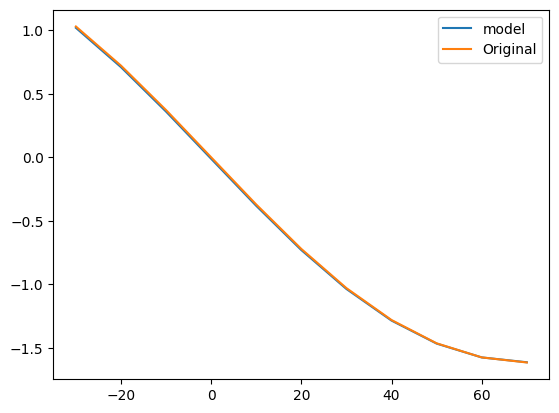

In [8]:
y_T = y1[0] - y0

q11s, q12s, q22s = q11, q12, q22

C = q11s
B = -2*q11s*x0 + 2*q12s*y_T
E = q11s*x0**2 - 2*q12s*x0*y_T + q22s*y_T**2

# modelled V_N
exponent = -(C*x1**2 + B*x1 + E) / Rc**2
VN = - (2*C*x1 + B) / Rc**2 * np.exp(exponent)

plt.plot(x1, VN* scale_opt , label='model')
plt.plot(x1, v1, label='Original')
plt.legend()


#### Reconstruct

In [9]:
def gaussian_vel_reconstruction(x0, y0, q11, q12, q22, R):

    q11, q12, q22 = np.abs(q11), np.abs(q12), np.abs(q22)
    
    width = 200
    x = np.linspace(x0-width, x0+width, 51)
    y = np.linspace(y0-width, y0+width, 51)
    X, Y = np.meshgrid(x, y)
    
    dx, dy = X - x0, Y - y0
    
    phi   = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
    phi_x = 2*q11*dx  + 2*q12*dy
    phi_y = 2*q22*dy  + 2*q12*dx
    
    # 5) build Gaussian streamfunction with that R
    exp_term = np.exp(-phi / R**2)
    psi_x = -phi_x / R**2 * exp_term
    psi_y = -phi_y / R**2 * exp_term
    
    u = -psi_y 
    v =  psi_x 

    return u, v, X, Y

u_new, v_new, X_new, Y_new = gaussian_vel_reconstruction(x0, y0, q11, q12, q22, Rc)

def vel_scalar(x1, y1, u1, v1, x2, y2, u2, v2, u, v, X, Y):
    points = np.column_stack((X.ravel(), Y.ravel()))
    values_v, values_u = v.ravel(), u.ravel()
    
    # Query at new points
    v1_psi = griddata(points, values_v, (x1, y1), method='linear')
    u1_psi = griddata(points, values_u, (x1, y1), method='linear')
    v2_psi = griddata(points, values_v, (x2, y2), method='linear')
    u2_psi = griddata(points, values_u, (x2, y2), method='linear')
    
    def objective(scale):
        return np.sum((u1 - u1_psi * scale)**2 + (v1 - v1_psi * scale)**2) + np.sum((u2 - u2_psi * scale)**2 + (v2 - v2_psi * scale)**2)
    
    res = minimize_scalar(objective)
    scale_opt = res.x
    
    u *= scale_opt
    v *= scale_opt

    v1_psi *= scale_opt
    u1_psi *= scale_opt
    v2_psi *= scale_opt
    u2_psi *= scale_opt

    print(f'Optimal Scale = {scale_opt}')
    
    return u, v, u1_psi, v1_psi, u2_psi, v2_psi

u_new, v_new, u1_psi, v1_psi, u2_psi, v2_psi = vel_scalar(x1, y1, u1, v1, x2, y2, u2, v2, u_new, v_new, X_new, Y_new)


Optimal Scale = 196.97896813309558


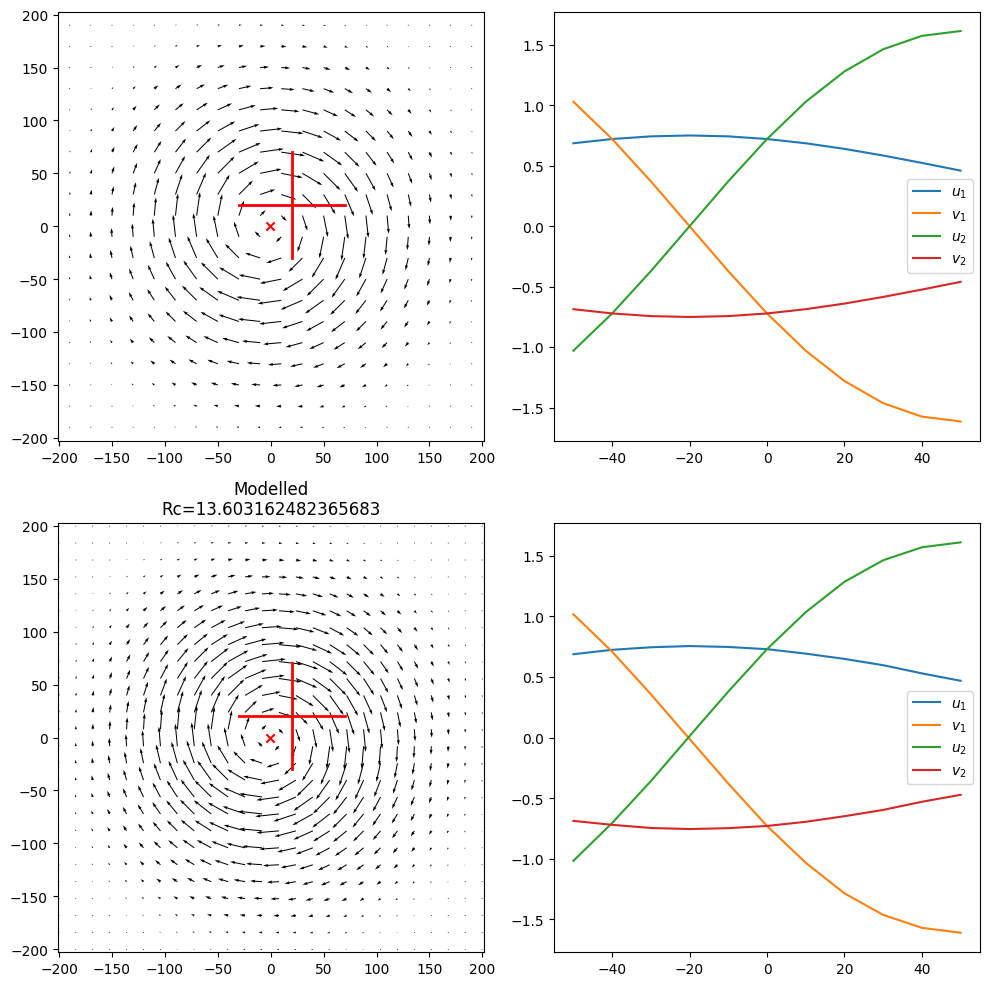

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
quiv_scale = 30

spacing = 2
axs[0,0].quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
           u[::spacing, ::spacing], v[::spacing, ::spacing], scale=quiv_scale)
axs[0,0].scatter(x0, y0, marker='x', color='r')

axs[0,0].plot(x1, y1, color='r', linewidth=2, zorder=1)
axs[0,0].plot(x2, y2, color='r', linewidth=2, zorder=1)

axs[0,0].axis('equal')
axs[0,0].set_xlim(-200, 200)
axs[0,0].set_ylim(-200, 200)

axs[0,1].plot(xx, u1, label=r'$u_1$')
axs[0,1].plot(xx, v1, label=r'$v_1$')
axs[0,1].plot(yy, u2, label=r'$u_2$')
axs[0,1].plot(yy, v2, label=r'$v_2$')
axs[0,1].legend()

# axs[1,0].pcolor(X_new, Y_new, np.hypot(u_new, v_new))
# axs[1,0].colorbar()
spacing = 2
axs[1,0].quiver(X_new[::spacing, ::spacing], Y_new[::spacing, ::spacing],
           u_new[::spacing, ::spacing], v_new[::spacing, ::spacing], scale=quiv_scale)

axs[1,0].plot(x1, y1, color='r', linewidth=2, zorder=1)
axs[1,0].plot(x2, y2, color='r', linewidth=2, zorder=1)
axs[1,0].scatter(x0, y0, marker='x', color='r')
axs[1,0].set_title(f'Modelled\nRc={Rc}')

axs[1,0].axis('equal')
axs[1,0].set_xlim(-200, 200)
axs[1,0].set_ylim(-200, 200)

axs[1,1].plot(xx, u1_psi, label=r'$u_1$')
axs[1,1].plot(xx, v1_psi, label=r'$v_1$')
axs[1,1].plot(yy, u2_psi, label=r'$u_2$')
axs[1,1].plot(yy, v2_psi, label=r'$v_2$')
axs[1,1].legend()

plt.tight_layout()
plt.show()


## ROMS

In [11]:
fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

with open('/srv/scratch/z5297792/Chapter2/dic_sample.pkl', 'rb') as f:
    dic_sample = pickle.load(f)
sample_eddies = list(dic_sample.keys())

df_eddies = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")


In [12]:
sample_eddies

['Eddy2749',
 'Eddy8',
 'Eddy2504',
 'Eddy896',
 'Eddy1394',
 'Eddy382',
 'Eddy1967',
 'Eddy926']

In [27]:
eddy = sample_eddies[6]
dic = dic_sample[eddy]
day = list(dic.keys())[10]
df_snapshot = dic[day]

fname = df_eddies[(df_eddies['ID']==int(eddy[4:]))&(df_eddies['Day']==int(day[3:]))].iloc[0]['fname']
fnumber = fname[-8:-3]
u_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')
v_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')
u_raw = np.where(u_raw > 1e30, np.nan, u_raw).astype(float)
v_raw = np.where(v_raw > 1e30, np.nan, v_raw).astype(float)
with nc.Dataset(fname) as dataset:
    ocean_time = dataset.variables['ocean_time'][:].data / 86400
t_rel = np.where(ocean_time == int(day[3:]))[0][0]

k = 0
data = df_snapshot.iloc[k]
x0, y0, Q, w, depth = data.x, data.y, data.Q, data.w, data.Depth
q11, q12, q22 = Q[0,0], Q[1,0], Q[1,1]
print(q11, q12, q22)

u, v = u_raw[:, :, k, t_rel], v_raw[:, :, k, t_rel]
u = np.where(mask_rho, u, np.nan)
v = np.where(mask_rho, v, np.nan)

# Extract Eddy Domain
mask = np.hypot(X_grid - x0, Y_grid - y0) <= 200
i_mask, j_mask = np.where(mask)
i_mask = np.arange(i_mask.min(), i_mask.max() + 1)
j_mask = np.arange(j_mask.min(), j_mask.max() + 1)
i_mask, j_mask = np.meshgrid(i_mask, j_mask)
i_mask, j_mask = i_mask.flatten(), j_mask.flatten()

i_min, j_min = i_mask.min(), j_mask.min()
i_range, j_range = i_mask.max() - i_min + 1, j_mask.max() - j_min + 1

u_eddy_domain = np.zeros((i_range, j_range))
v_eddy_domain = np.zeros((i_range, j_range))
X_eddy_domain = np.zeros((i_range, j_range))
Y_eddy_domain = np.zeros((i_range, j_range))
x_eddy_domain, y_eddy_domain = X_eddy_domain[:,0], Y_eddy_domain[0,:]

for i, j in zip(i_mask, j_mask):
    u_eddy_domain[i - i_min, j - j_min] = u[i, j]
    v_eddy_domain[i - i_min, j - j_min] = v[i, j]
    X_eddy_domain[i - i_min, j - j_min] = X_grid[i, j]
    Y_eddy_domain[i - i_min, j - j_min] = Y_grid[i, j]


-0.008418143656544594 -0.000479935766615009 -0.007305326419901507


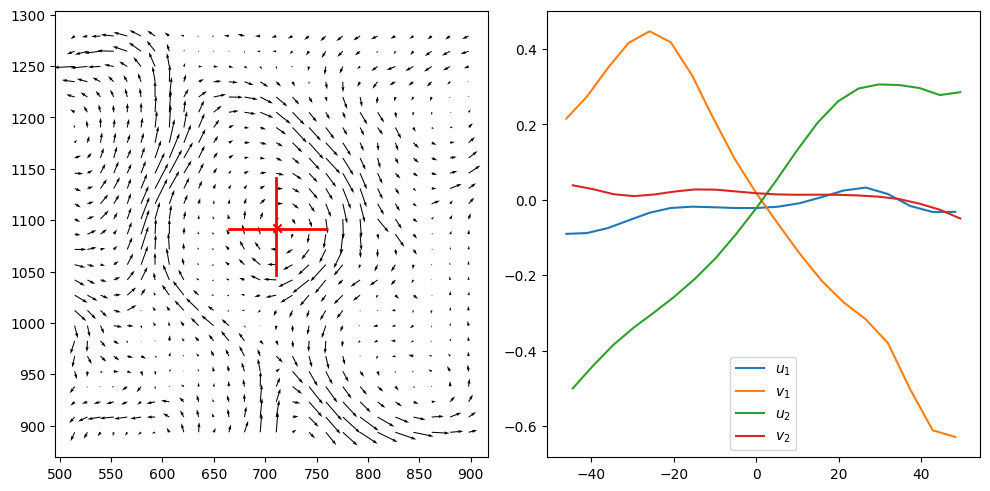

In [28]:
r = 50

dis = np.hypot(X_eddy_domain - x0, Y_eddy_domain - y0)
ic, jc = np.where(dis == np.min(dis))

x_mask = np.abs(x_eddy_domain - x0) < r
x1 = x_eddy_domain[x_mask]
y1 = np.full_like(x1, y_eddy_domain[jc])
u1 = u_eddy_domain[x_mask, jc]
v1 = v_eddy_domain[x_mask, jc]

y_mask = np.abs(y_eddy_domain - y0) < r
y2 = y_eddy_domain[y_mask]
x2 = np.full_like(y2, x_eddy_domain[ic])
u2 = u_eddy_domain[ic, y_mask]
v2 = v_eddy_domain[ic, y_mask]

points1 = set(map(tuple, zip(x1.ravel(), y1.ravel())))
points2 = set(map(tuple, zip(x2.ravel(), y2.ravel())))
common_points = points1 & points2

if not common_points:
    raise ValueError("No common points found.")

center_x, center_y = next(iter(common_points))
xx = x1 - center_x
yy = y2 - center_y

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

spacing = 3
axs[0].quiver(X_eddy_domain[::spacing, ::spacing], Y_eddy_domain[::spacing, ::spacing],
           u_eddy_domain[::spacing, ::spacing], v_eddy_domain[::spacing, ::spacing])
axs[0].scatter(x0, y0, marker='x', color='r')
axs[0].axis('equal')

axs[0].plot(x1, y1, color='r', linewidth=2, zorder=1)
axs[0].plot(x2, y2, color='r', linewidth=2, zorder=1)

axs[1].plot(xx, u1, label=r'$u_1$')
axs[1].plot(xx, v1, label=r'$v_1$')
axs[1].plot(yy, u2, label=r'$u_2$')
axs[1].plot(yy, v2, label=r'$v_2$')
axs[1].legend()

plt.tight_layout()
plt.show()


In [29]:
scale_opt, Rc = fit_Rc(x1, y1, v1, q11, q12, q22, x0, y0)
print("Optimal Rc =", Rc)
print("Optimal Scale =", scale_opt)


Optimal Rc = 10.203480058626376
Optimal Scale = 1e-06


In [30]:
u, v, X, Y = gaussian_vel_reconstruction(x0, y0, q11, q12, q22, Rc)

u, v, u1_psi, v1_psi, u2_psi, v2_psi = vel_scalar(x1, y1, u1, v1, x2, y2, u2, v2, u, v, X, Y)


Optimal Scale = 79.102341130922


In [31]:
X_eddy_domain[1,0]-X_eddy_domain[0,0]

np.float64(4.120441598916727)

In [32]:
X[0,1]-X[0,0]

np.float64(8.0)

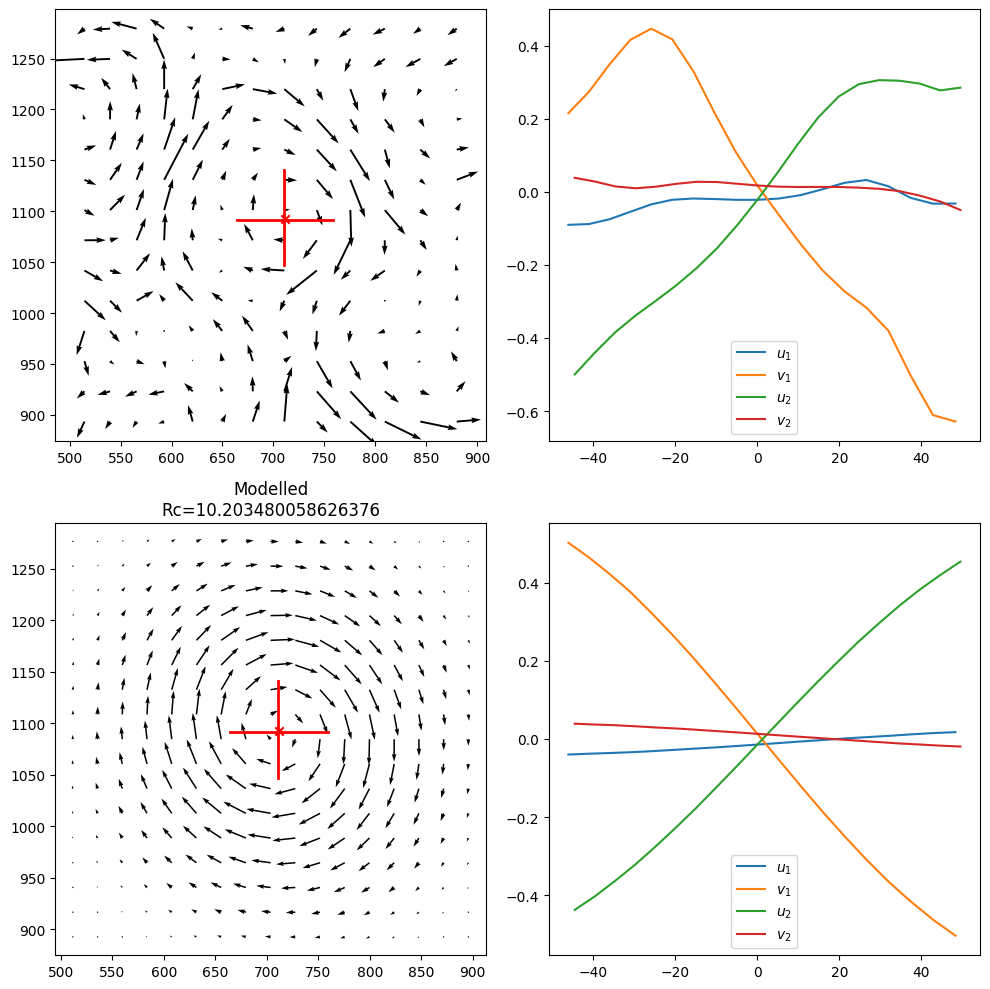

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
quiv_scale = 10

spacing = 6
axs[0,0].quiver(X_eddy_domain[::spacing, ::spacing], Y_eddy_domain[::spacing, ::spacing],
           u_eddy_domain[::spacing, ::spacing], v_eddy_domain[::spacing, ::spacing], scale=quiv_scale)
axs[0,0].scatter(x0, y0, marker='x', color='r')
axs[0,0].axis('equal')

axs[0,0].plot(x1, y1, color='r', linewidth=2, zorder=1)
axs[0,0].plot(x2, y2, color='r', linewidth=2, zorder=1)

axs[0,1].plot(xx, u1, label=r'$u_1$')
axs[0,1].plot(xx, v1, label=r'$v_1$')
axs[0,1].plot(yy, u2, label=r'$u_2$')
axs[0,1].plot(yy, v2, label=r'$v_2$')
axs[0,1].legend()

# axs[1,0].pcolor(X, Y, np.hypot(u, v))
# axs[1,0].colorbar()
spacing = 3
axs[1,0].quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
           u[::spacing, ::spacing], v[::spacing, ::spacing], scale=quiv_scale)
axs[1,0].axis('equal')

axs[1,0].plot(x1, y1, color='r', linewidth=2, zorder=1)
axs[1,0].plot(x2, y2, color='r', linewidth=2, zorder=1)
axs[1,0].scatter(x0, y0, marker='x', color='r')
axs[1,0].set_title(f'Modelled\nRc={Rc}')

axs[1,1].plot(xx, u1_psi, label=r'$u_1$')
axs[1,1].plot(xx, v1_psi, label=r'$v_1$')
axs[1,1].plot(yy, u2_psi, label=r'$u_2$')
axs[1,1].plot(yy, v2_psi, label=r'$v_2$')
axs[1,1].legend()

plt.tight_layout()
plt.show()
